# Trends in Voter Registration in October 2018 versus November 2018 Results

Exploring the simplest correlation possible - voter registration and party vote share - to check for the existence of any correlations that a more sophisticated model might capture.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

# Use the Gill Sans font
import matplotlib.pylab as pylab

import numpy as np

import matplotlib.font_manager as fm
font = fm.FontProperties(
       family = 'Gill Sans',
       fname = '/usr/share/fonts/truetype/adf/GilliusADF-Regular.otf')
params = {
         'font.size': 14,
         'font.style': 'italic',
         'legend.fontsize': 14,
         'figure.figsize': (9.5, 6),
         'axes.labelsize': 14,
         'axes.titlesize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14,
         'axes.spines.right' : False,
         'axes.spines.left' : True,
         'axes.spines.top' : False,
         'axes.spines.bottom' : True,
         'font.family' : 'Gill Sans'}
pylab.rcParams.update(params)

## Data Cleaning

### Election Results Data

Reading in the November 2018 election results data, isolating State Senate races, and digesting their outcomes

In [2]:
election_df = pd.read_excel('../data/results/raw/2018.xlsx')
election_df.head()

,OFFICE/BALLOT ISSUE NUMBER,PARTY,COUNTY,CANDIDATE/JUDGE/BALLOT TITLE,YES VOTES,YES PERCENT,NO VOTES,NO PERCENT
0,United States Representative - District 1,Republican Party,ARAPAHOE,Charles Casper Stockham,8300,0.0224,NaN,NaN
1,United States Representative - District 1,Republican Party,DENVER,Charles Casper Stockham,57186,0.1547,NaN,NaN
2,United States Representative - District 1,Republican Party,JEFFERSON,Charles Casper Stockham,19721,0.0533,NaN,NaN
3,United States Representative - District 1,Republican Party,TOTAL,Charles Casper Stockham,85207,0.2305,NaN,NaN
4,United States Representative - District 1,Democratic Party,ARAPAHOE,Diana DeGette,15645,0.0423,NaN,NaN


Pluck out State Senate election results as a separate dataframe

In [3]:
state_senate_df = election_df[election_df['OFFICE/BALLOT ISSUE NUMBER'].str.contains('State Senate')]
state_senate_df['OFFICE/BALLOT ISSUE NUMBER'] = state_senate_df['OFFICE/BALLOT ISSUE NUMBER'].str.replace('State Senate - District', 'SD')
county_vals = (state_senate_df.COUNTY != 'TOTAL')
state_senate_df = state_senate_df[county_vals]
elections = state_senate_df['OFFICE/BALLOT ISSUE NUMBER'].unique()
print(state_senate_df)

     OFFICE/BALLOT ISSUE NUMBER             PARTY      COUNTY  \
1778                       SD 1  Republican Party    CHEYENNE   
1779                       SD 1  Republican Party      ELBERT   
1780                       SD 1  Republican Party  KIT CARSON   
1781                       SD 1  Republican Party     LINCOLN   
1782                       SD 1  Republican Party       LOGAN   
...                         ...               ...         ...   
1913                      SD 32  Democratic Party      DENVER   
1915                      SD 32  Republican Party      DENVER   
1917                      SD 32       Independent      DENVER   
1919                      SD 34  Democratic Party      DENVER   
1921                      SD 34  Republican Party      DENVER   

     CANDIDATE/JUDGE/BALLOT TITLE YES VOTES  YES PERCENT  NO VOTES  NO PERCENT  
1778             Jerry Sonnenberg       829       0.0125       NaN         NaN  
1779             Jerry Sonnenberg     11132       0.1681 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Voter Registration Data

Reading in and digesting the October 2020 voter registration data by county and State Senate district

In [4]:
columns = ['DISTRICT', 'COUNTY', 
           'ACN-ACTIVE', 'APV-ACTIVE', 'DEM-ACTIVE', 'GRN-ACTIVE', 'LBR-ACTIVE', 'REP-ACTIVE',
       'UAF-ACTIVE', 'UNI-ACTIVE', 'TOTAL-ACTIVE', 
           'ACN-INACTIVE', 'APV-INACTIVE', 'DEM-INACTIVE', 'GRN-INACTIVE',
       'LBR-INACTIVE', 'REP-INACTIVE', 'UAF-INACTIVE', 'UNI-INACTIVE', 'TOTAL-INACTIVE', 
           'ACN-PREREG', 'APV-PREREG',
       'DEM-PREREG', 'GRN-PREREG', 'LBR-PREREG', 'REP-PREREG', 'UAF-PREREG', 'UNI-PREREG', 'TOTAL-PREREG',
           'TOTAL']

voter_affiliation_df = pd.read_excel('../data/registration/raw/2018.xlsx', 'State Senate Districts', 
                                    header=2, names=columns)

# empty squares have no voters
voter_affiliation_df = voter_affiliation_df.fillna(0)

# Remove each "Total" County instance
county_vals = (voter_affiliation_df.COUNTY != 'Total')
voter_affiliation_df = voter_affiliation_df[county_vals]
print(voter_affiliation_df)

        DISTRICT      COUNTY  ACN-ACTIVE  APV-ACTIVE  DEM-ACTIVE  GRN-ACTIVE  \
0           SD 1  Kit Carson        16.0         1.0         519         6.0   
1           SD 1     Lincoln        12.0         0.0         377         3.0   
2           SD 1       Logan        47.0         1.0        1665        12.0   
3           SD 1      Morgan        68.0         3.0        2859        18.0   
4           SD 1    Phillips         5.0         0.0         374         3.0   
..           ...         ...         ...         ...         ...         ...   
118        SD 35      Pueblo        50.0         0.0        3877        24.0   
119        SD 35  Rio Grande        32.0         0.0        2068        16.0   
120        SD 35    Saguache        14.0         0.0        1570        27.0   
121        SD 35           0       356.0         2.0       27166       199.0   
122  State Total           0     10411.0       163.0     1038975      9857.0   

     LBR-ACTIVE  REP-ACTIVE  UAF-ACTIVE

For the sake of simplicity, assume everyone who isn't a Republican or Democrat is "Other", and look at that as a massed group.

In [5]:
collapsed_columns = {'ACN-ACTIVE' : 'OTHER-ACTIVE', 
                     'APV-ACTIVE' : 'OTHER-ACTIVE', 
                     'GRN-ACTIVE' : 'OTHER-ACTIVE', 
                     'LBR-ACTIVE' : 'OTHER-ACTIVE', 
                     'UAF-ACTIVE' : 'OTHER-ACTIVE', 
                     'UNI-ACTIVE' : 'OTHER-ACTIVE', 
                     'ACN-INACTIVE' : 'OTHER-INACTIVE', 
                     'APV-INACTIVE' : 'OTHER-INACTIVE', 
                     'DEM-INACTIVE' : 'OTHER-INACTIVE', 
                     'GRN-INACTIVE' : 'OTHER-INACTIVE',
                     'LBR-INACTIVE' : 'OTHER-INACTIVE', 
                     'REP-INACTIVE' : 'OTHER-INACTIVE', 
                     'UAF-INACTIVE' : 'OTHER-INACTIVE', 
                     'UNI-INACTIVE' : 'OTHER-INACTIVE',
                     'ACN-PREREG' : 'OTHER-PREREG', 
                     'APV-PREREG' : 'OTHER-PREREG',
                     'DEM-PREREG' : 'OTHER-PREREG', 
                     'GRN-PREREG' : 'OTHER-PREREG', 
                     'LBR-PREREG' : 'OTHER-PREREG', 
                     'REP-PREREG' : 'OTHER-PREREG', 
                     'UAF-PREREG' : 'OTHER-PREREG', 
                     'UNI-PREREG' : 'OTHER-PREREG',
                     'DISTRICT' : 'DISTRICT', 
                     'COUNTY' : 'COUNTY', 
                     'DEM-ACTIVE' : 'DEM-ACTIVE', 
                     'REP-ACTIVE' : 'REP-ACTIVE', 
                     'TOTAL-ACTIVE' : 'TOTAL-ACTIVE', 
                     'DEM-INACTIVE' : 'DEM-INACTIVE', 
                     'REP-INACTIVE' : 'REP-INACTIVE', 
                     'TOTAL-INACTIVE' : 'TOTAL-INACTIVE', 
                     'DEM-PREREG' : 'DEM-PREPREG', 
                     'REP-PREREG' : 'REP-PREREG', 
                     'TOTAL-PREREG' : 'TOTAL-PREREG',
                     'TOTAL' : 'TOTAL'
                    }

voter_affiliation_df = voter_affiliation_df.groupby(collapsed_columns, axis=1).sum()

voter_affiliation_df['COUNTY'] = voter_affiliation_df['COUNTY'].str.upper()
print(voter_affiliation_df)

         COUNTY  DEM-ACTIVE  DEM-INACTIVE  DEM-PREPREG     DISTRICT  \
0    KIT CARSON         519            85          4.0         SD 1   
1       LINCOLN         377            73          0.0         SD 1   
2         LOGAN        1665           279          1.0         SD 1   
3        MORGAN        2859           332          7.0         SD 1   
4      PHILLIPS         374           121          2.0         SD 1   
..          ...         ...           ...          ...          ...   
118      PUEBLO        3877           242         28.0        SD 35   
119  RIO GRANDE        2068           314          3.0        SD 35   
120    SAGUACHE        1570           242          0.0        SD 35   
121         NaN       27166          3558         83.0        SD 35   
122         NaN     1038975        144932       8420.0  State Total   

     OTHER-ACTIVE  OTHER-INACTIVE  OTHER-PREREG  REP-ACTIVE  REP-INACTIVE  \
0          1327.0           338.0          22.0        2507           

## Election Analysis

Goal here is to look at active voters in each party versus how the vote broke in each county and Senate District election. This leads to a 3x3 plot that shows the fraction of total active voters in each party for each county and Senate District, and then the fraction of the votes from that county that went to each party, D/R/Other.

In [6]:
regs_dict={'D' : [],
          'R' : [],
          'O' : []}

votes_dict={'D' : [],
           'R' : [],
           'O' : []}

tot_votes = []

print_output = False

for election in elections:
    district_election = state_senate_df[state_senate_df['OFFICE/BALLOT ISSUE NUMBER'] == election]
    district_voters   = voter_affiliation_df[voter_affiliation_df['DISTRICT'] == election]
    for county in district_election.COUNTY.unique():
        # Get total active voters from a district
        if district_voters[district_voters.COUNTY == county].empty:
            pass
        else:
            tot_votes.append(district_voters[district_voters.COUNTY == county]['TOTAL-ACTIVE'].values[0])
            # Party affiliation of active voters as fraction of total active voters
            county_voters = (district_voters.COUNTY == county)
            Ds = district_voters[county_voters]['DEM-ACTIVE'].values[0]
            Rs = district_voters[county_voters]['REP-ACTIVE'].values[0]
            Os = district_voters[county_voters]['OTHER-ACTIVE'].values[0]
            regs_dict['D'].append(1.*Ds/(Ds+Rs+Os))
            regs_dict['R'].append(1.*Rs/(Ds+Rs+Os))
            regs_dict['O'].append(1.*Os/(Ds+Rs+Os))

            # Total votes cast
            county_election = (district_election['COUNTY']==county)

            if len(district_election[county_election][district_election[county_election].PARTY == 'Democratic Party']):
                dem_votes = district_election[county_election][district_election[county_election].PARTY == 'Democratic Party']['YES VOTES'].values[0]
            if len(district_election[county_election][district_election[county_election].PARTY == 'Republican Party']):
                rep_votes = district_election[county_election][district_election[county_election].PARTY == 'Republican Party']['YES VOTES'].values[0]

            other_candidates = (district_election[county_election].PARTY != 'Republican Party') & (district_election[county_election].PARTY != 'Democratic Party')
            other_votes = district_election[county_election][other_candidates]['YES VOTES'].sum()

            votes_cast = dem_votes + rep_votes + other_votes

            if print_output:

                print('Election {} in {} county \n'.format(election, county))
                print('dem vote fraction = {}'.format(dem_votes/votes_cast))
                print('rep vote fraction = {}'.format(rep_votes/votes_cast))
                print('other vote fraction = {}'.format(other_votes/votes_cast))
                print('-----')

            votes_dict['D'].append(dem_votes/votes_cast)
            votes_dict['R'].append(rep_votes/votes_cast)
            votes_dict['O'].append(other_votes/votes_cast)

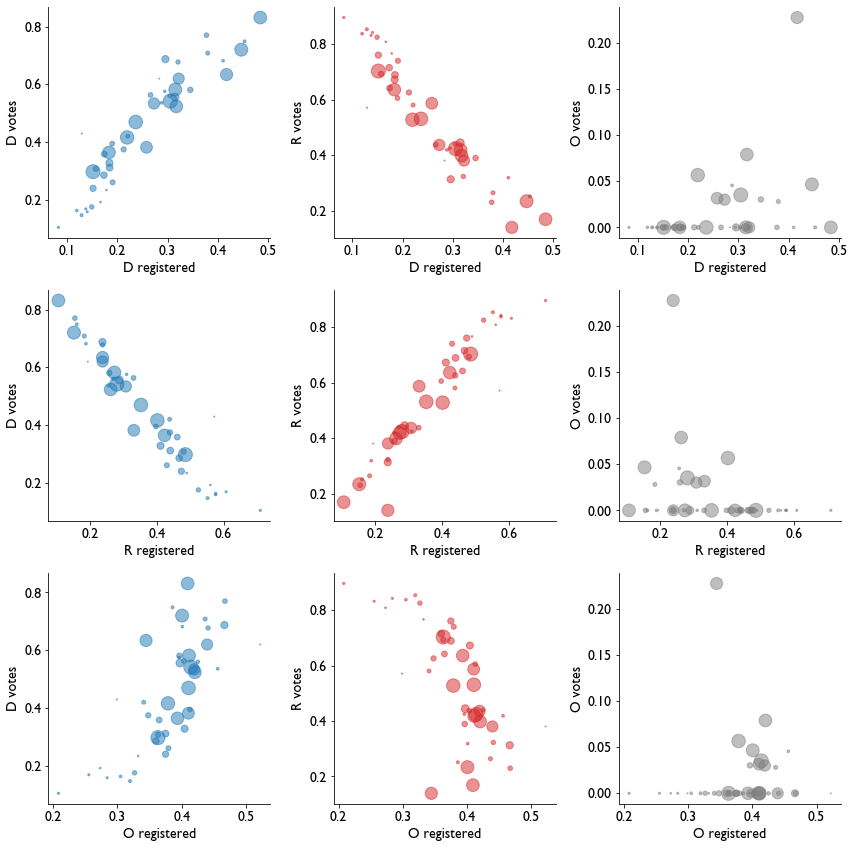

In [7]:
fig, ax = plt.subplots(3,3, figsize = (12,12))
ax_idx1 = 0
ax_idx2 = 0
vote_keys = ['D', 'R', 'O']
regs_keys = ['D', 'R', 'O']

color_key = {'D' :'tab:blue',
            'R' : 'tab:red',
            'O' : 'tab:gray'}
                       #[ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33]
#fig.title('Registration as Fraction of Voting Body')

for vote_key in vote_keys:
    for regs_key in regs_keys:
        this_ax = ax[ax_idx1][ax_idx2]
        this_ax.scatter(regs_dict[regs_key], votes_dict[vote_key], 
                           s = tot_votes/min(tot_votes), 
                           label='{} vs {}'.format(regs_key, vote_key),
                            c = color_key[vote_key],
                           alpha=0.5)
        this_ax.set_xlabel('{} registered'.format(regs_key))
        this_ax.set_ylabel('{} votes'.format(vote_key))
        ax_idx1 += 1
    ax_idx1 = 0
    ax_idx2 += 1
fig.tight_layout()
fig.savefig('figs/votes_vs_regs.png')

pass;

There is a very strong linear relationship between Democratic and Republican registration as a fraction of vote and the actual vote total. Let's try fitting a sigmoid function to the data

3
0.43745383708888674
D voters
 wd = 2.827671360861114 
 wr = -3.6242596827687694 
 w0 = 0.9931586029781634
0.008116819940387526
0.008116819940387526
0.008116819940387526
0.5472227711029336
R voters
 wd = -4.217792126212492 
 wr = 3.3949431085520456 
 w0 = -0.0444244818293213
0.008487305846616075
0.008487305846616075
0.008487305846616075
559985.093759218
O voters
 wd = 159.12490424377089 
 wr = 33.763298007373756 
 w0 = -219.66047047229463
0.0030205168198417713
0.0030205168198417713


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


0.0030205168198417713


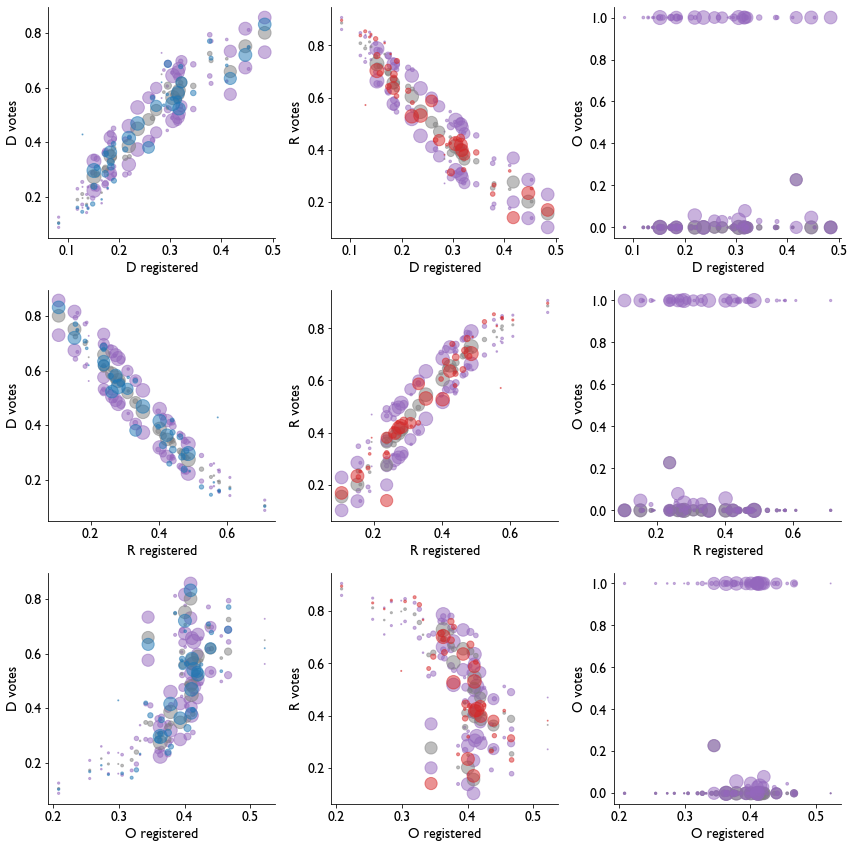

In [8]:
from scipy.optimize import curve_fit
import numpy as np

def sigmoid(X, wd, wr, wo):
    dems, reps, other = np.array(X)
    xx = wd*dems + wr*reps + wo*other
    return 1./(1. + np.exp(- (xx)))

fig, ax = plt.subplots(3,3, figsize = (12,12))
print(len(ax))
ax_idx1 = 0
ax_idx2 = 0
vote_keys = ['D', 'R', 'O']
regs_keys = ['D', 'R', 'O']

color_key = {'D' :'tab:blue',
            'R' : 'tab:red',
            'O' : 'tab:purple'}
                       #[ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33]
#fig.title('Registration as Fraction of Voting Body')
reg_dict = {}

for vote_key in vote_keys:
    
    # fit the sigmoid curve
    [wd, wr, wo], pcov = curve_fit(sigmoid, [regs_dict['D'], regs_dict['R'], regs_dict['O']], votes_dict[vote_key])
    print(pcov[0,0])
    print('{} voters'.format(vote_key))
    print(' wd = {} \n wr = {} \n w0 = {}'.format(wd, wr, wo))
    y = sigmoid([regs_dict['D'], regs_dict['R'], regs_dict['O']], wd, wr, wo)
    y_plus = sigmoid([regs_dict['D'], regs_dict['R'], regs_dict['O']], wd+pcov[0,0], wr+pcov[1,1], wo+pcov[2,2])
    y_minus = sigmoid([regs_dict['D'], regs_dict['R'], regs_dict['O']], wd-pcov[0,0], wr-pcov[1,1], wo-pcov[2,2])
    reg_dict[vote_key] = [wd, wr, wo]
    
    for regs_key in regs_keys:

        this_ax = ax[ax_idx1][ax_idx2]
        
        # plot projected vote fraction in black)
        this_ax.scatter(regs_dict[regs_key], y_plus, s=tot_votes/min(tot_votes), c='tab:purple', alpha=0.5)
        this_ax.scatter(regs_dict[regs_key], y_minus, s=tot_votes/min(tot_votes), c='tab:purple', alpha=0.5)
        this_ax.scatter(regs_dict[regs_key], y, s=tot_votes/min(tot_votes), c='tab:gray', alpha=0.5);
        x = np.linspace(0., .5, 100)
        
        
        # plot actual vote fraction in partisan color
        this_ax.scatter(regs_dict[regs_key], votes_dict[vote_key], 
                           s = tot_votes/min(tot_votes), 
                           label='{} vs {}'.format(regs_key, vote_key),
                            c = color_key[vote_key],
                           alpha=0.5)


        print(np.sqrt(np.sum((np.array(y)-np.array(votes_dict[vote_key]))**2))/len(votes_dict[vote_key]))


        this_ax.set_xlabel('{} registered'.format(regs_key));
        this_ax.set_ylabel('{} votes'.format(vote_key));
        ax_idx1 += 1
    ax_idx1 = 0
    ax_idx2 += 1
fig.tight_layout()
fig.savefig('figs/votes_vs_regs_regression.png')

pass;